# Data Cleaning and Processing
**Purpose**  
I investigate the data with intent to polish it for the model. This improves model performance and makes the experiment more realistic.

*High Level Approach* 
 * Determine list of words to remove from the text data
 * Compare differences in text and title data
 * Get an idea for the added predictive power of bigrams and trigrams
 * Find and comprehend any placeholders

**Note:**  

EDA is only done on the smallest of the two datasets. This is sufficient because all data comes from the same population of all posts under the given subreddit. There is an implicit assumption that the eda done on the smallest two datasets reveals features representative of the entire population.

In [56]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction import text as text_sk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [57]:
import httpimport
url = 'https://raw.githubusercontent.com/zach-brown-18/class-toolkit/main/eda/'
with httpimport.remote_repo(['nan','columns','nlp'], url):
    import nan, columns, nlp

---

# First look at the data

In [58]:
oceans = pd.read_csv('../data/raw/oceans.csv')
diving = pd.read_csv('../data/raw/diving.csv')

In [59]:
print(oceans.shape)
print(diving.shape)

(1800, 3)
(1200, 3)


In [60]:
oceans.head()

,subreddit,selftext,title
0,oceans,NaN,Perfect reflection 💎
1,oceans,NaN,It's my fav view
2,oceans,NaN,Abalone - The large marine gastropod mollusks....
3,oceans,How deep is the continental shelf typically an...,Depth of the Continental Shelf
4,oceans,NaN,"happy birthday to me,happy christmas eve,happy..."


In [61]:
diving.head()

,subreddit,selftext,title
0,diving,NaN,Found a luxury watch worth well over $1000 &am...
1,diving,NaN,Pool training anyone?
2,diving,NaN,Diving a couple dive sites in Nha Trang Vietnam
3,diving,Im going to get my first gear soon and im stuc...,Aqualung core supreme vs Scubapro mk17 c370
4,diving,[removed],Subea SCD100 Wetsuit advice


**Interpretation:** Lots of rows missing selftext. Some title's have special characters that have not loaded properly when called by the api. 

In [62]:
nan.investigate_null(oceans)

,column,null_count
0,selftext,1646


In [63]:
nan.investigate_null(diving)

,column,null_count
0,selftext,766


**Interpretation:** Title is mandatory for a post, a text body is not. I will try treating the two columns separately and combining them to see which performs better.

---
# Data Cleaning

In [64]:
# CountVectorizer can not handle nan
oceans['selftext'] = oceans['selftext'].fillna('').copy()
diving['selftext'] = diving['selftext'].fillna('').copy()

In [65]:
# Expanding Contractions
oceans['title'] = oceans['title'].apply(lambda x: nlp.expand_contractions(x))
oceans['selftext'] = oceans['selftext'].apply(lambda x: nlp.expand_contractions(x))
diving['title'] = diving['title'].apply(lambda x: nlp.expand_contractions(x))
diving['selftext'] = diving['selftext'].apply(lambda x: nlp.expand_contractions(x))

Credit to https://www.analyticsvidhya.com/blog/2020/04/beginners-guide-exploratory-data-analysis-text-data/ for expanding contractions idea.

In [66]:
# Combine text into a single column
oceans['all_text'] = oceans['title'] + ' ' + oceans['selftext']
diving['all_text'] = diving['title'] + ' ' + diving['selftext']

# EDA

# Title Column

## Keep all words

In [67]:
oceans_all_title = nlp.v_transform('title', oceans)
diving_all_title = nlp.v_transform('title', diving)

Shape: (1800, 4809)
Shape: (1200, 2978)


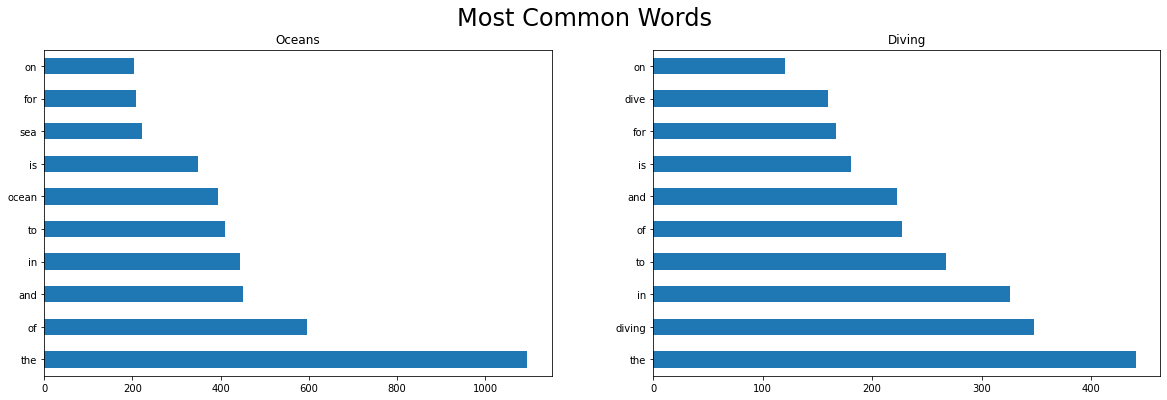

In [68]:
titles = ['Oceans', 'Diving']
nlp.plot_frequent([oceans_all_title, diving_all_title], titles)

**Interpretation:** The majority of the words on the two lists overlap. Sea, ocean, dive and diving stand out as useful.

## Remove Stop Words

**sklearn's standard stop words**

In [69]:
oceans_title = nlp.v_transform('title', oceans, stopwords='english')
diving_title = nlp.v_transform('title', diving, stopwords='english')

Shape: (1800, 4571)
Shape: (1200, 2778)


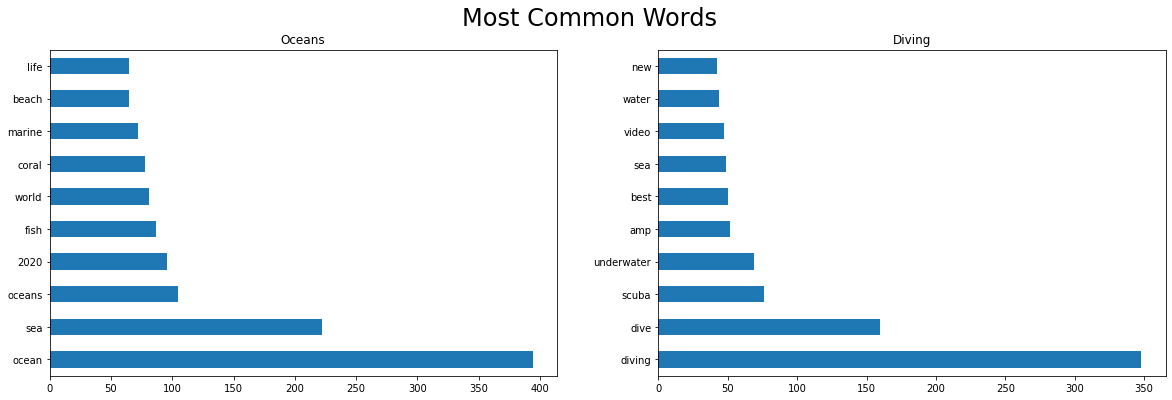

In [70]:
nlp.plot_frequent([oceans_title, diving_title], titles)

**Interpretation:** Ocean and diving are now (naturally) the most frequently occuring words. Only 'sea' appears in both lists - How can I minimize the effect of the word 'sea' - Try TfidfVectorizer. Interesting to see 2020 as the fourth most common word in the oceans subreddit.

## Bigrams and Trigrams

### Most Common Bigrams

In [71]:
oceans_bigrams = nlp.v_transform('title', oceans, stopwords='english', min_df=3, ngram_range=(2,2))
diving_bigrams = nlp.v_transform('title', diving, stopwords='english', min_df=3, ngram_range=(2,2))

Shape: (1800, 398)
Shape: (1200, 216)


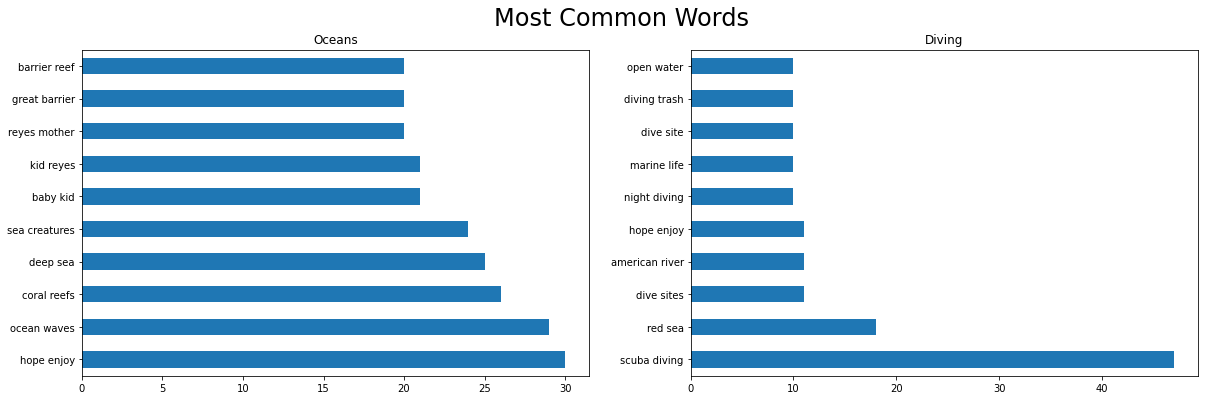

In [72]:
nlp.plot_frequent([oceans_bigrams, diving_bigrams], titles)

**Interpretation:** Bigrams will be useful in differentiating between these two subreddits. Consider removing 'hope enjoy' as this bigram occurs frequently in both subreddits.

### Most Common Trigrams

In [73]:
oceans_trigrams = nlp.v_transform('title', oceans, stopwords='english', min_df=3, ngram_range=(3,3))
diving_trigrams = nlp.v_transform('title', diving, stopwords='english', min_df=3, ngram_range=(3,3))

Shape: (1800, 230)
Shape: (1200, 96)


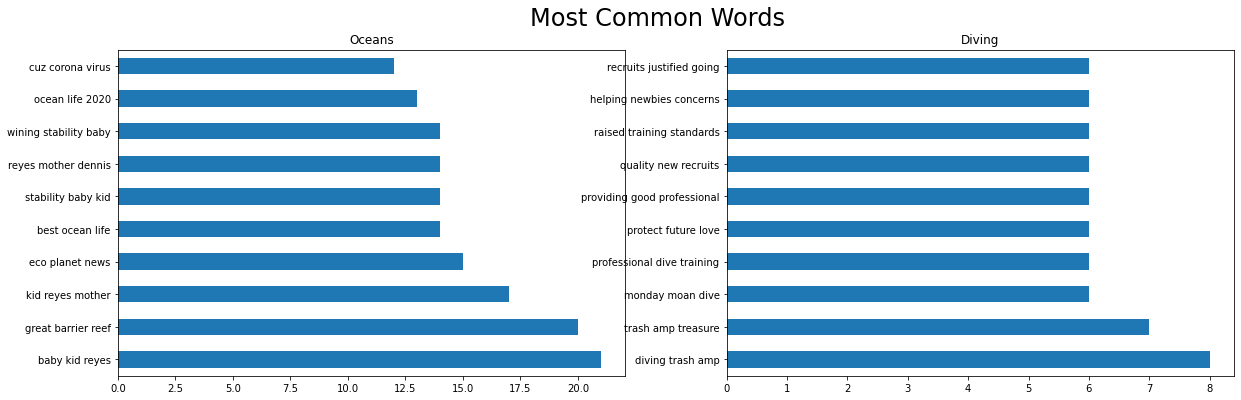

In [74]:
nlp.plot_frequent([oceans_trigrams, diving_trigrams], titles)

**Interpretation:** Harder to tell if these will be useful in differentiating between subreddits, particularly on new data.

In [75]:
# '2020 03 15' stands out as an example that is not likely to be useful when classifying new data.
oceans_trigrams['2020 03 15'].sum()

12

---
# Text Column

In [76]:
# Remove stopwords
oceans_text = nlp.v_transform('selftext', oceans, stopwords='english')
diving_text = nlp.v_transform('selftext', diving, stopwords='english')

Shape: (1800, 1682)
Shape: (1200, 3263)


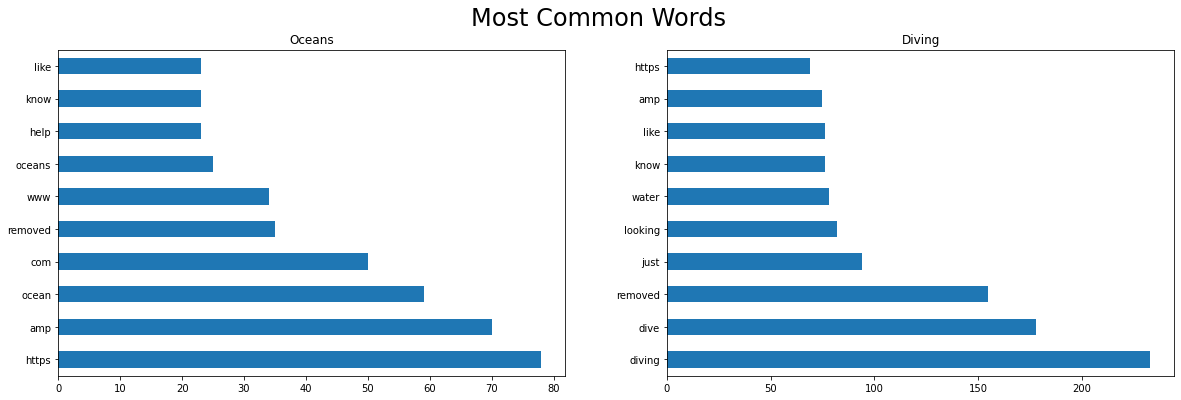

In [77]:
nlp.plot_frequent([oceans_text, diving_text], titles)

**Interpretation:** Must determine what converts to 'removed.' 'amp' may also be a placeholder - it appears frequently in the diving subreddit's titles alone and in the trigram 'diving trash amp.' The high frequency of 'https,' 'com,' and 'www' in the oceans subreddit's text body is not likely to be helpful in classifying posts if the model is used to classify posts from subreddits other than diving and oceans.

### Most Common Bigrams

In [78]:
oceans_bigrams_text = nlp.v_transform('selftext', oceans, stopwords='english', min_df=3, ngram_range=(2,2))
diving_bigrams_text = nlp.v_transform('selftext', diving, stopwords='english', min_df=3, ngram_range=(2,2))

Shape: (1800, 28)
Shape: (1200, 130)


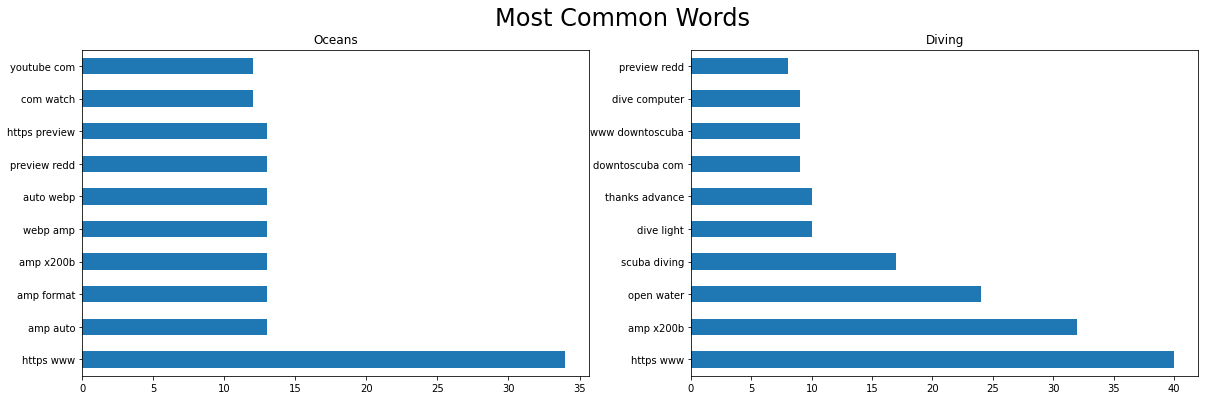

In [79]:
nlp.plot_frequent([oceans_bigrams_text, diving_bigrams_text], titles)

**Interpretation:** Hyperlinks, indicated by 'https www,' are prevalent in these two subreddits (and likely in many subreddits) and hence will not be useful in classifying a post.

### Most Common Trigrams

In [80]:
oceans_trigrams_text = nlp.v_transform('selftext', oceans, stopwords='english', min_df=3, ngram_range=(3,3))
diving_trigrams_text = nlp.v_transform('selftext', diving, stopwords='english', min_df=3, ngram_range=(3,3))

Shape: (1800, 19)
Shape: (1200, 27)


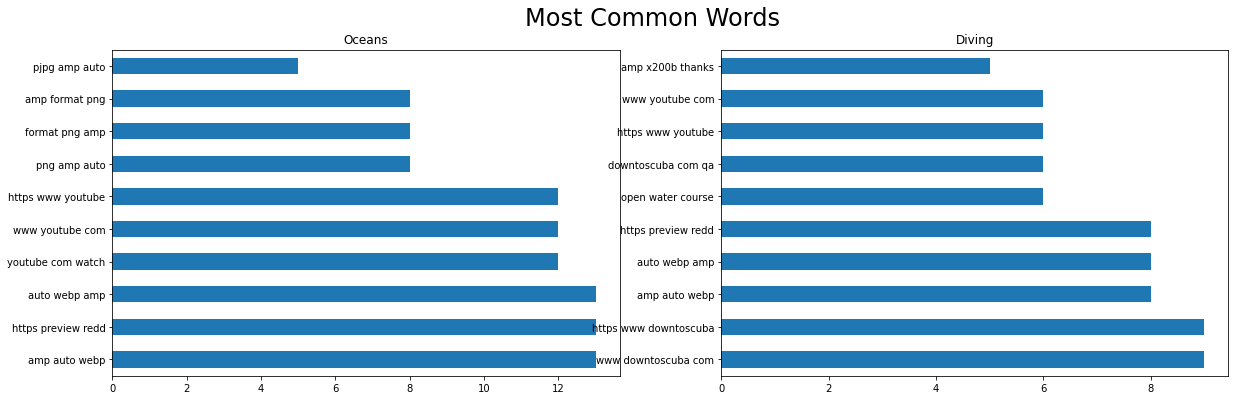

In [81]:
nlp.plot_frequent([oceans_trigrams_text, diving_trigrams_text], titles)

**Interpretation:** All generic links should be removed as stop words. 'amp' should be removed as well. It is an html element \<amp-img>

# Vectorizer Findings:
* Standard sklearn stopwords must be removed along with
    * A custom list of common web link and image html element stop words.
    * The words 'reddit' and 'redd' (an abbreviation for reddit)
* Consider removing certain date references to decrease variance ('2020 03 15').
* Combine 'title' and 'selftext' columns can be treated equally. Combine them into one column.
* What triggers the placeholder 'removed'?

---

# More Data Cleaning

### Remove Custom Stopwords

**Self Text**

In [82]:
web_link_stop_words = ['amp', 'webp', 'www', 'https', 'http', 'png', 'pjpg', 'com']
stop_words = text_sk.ENGLISH_STOP_WORDS.union(web_link_stop_words)

Approach to modifying sklearn's stopwords list found here https://stackoverflow.com/questions/24386489/adding-words-to-scikit-learns-countvectorizers-stop-list

In [83]:
oceans_clean = nlp.v_transform('selftext', oceans, min_df=3, stopwords=stop_words, ngram_range=(3,3))
diving_clean = nlp.v_transform('selftext', diving, min_df=3, stopwords=stop_words, ngram_range=(3,3))

Shape: (1800, 3)
Shape: (1200, 10)


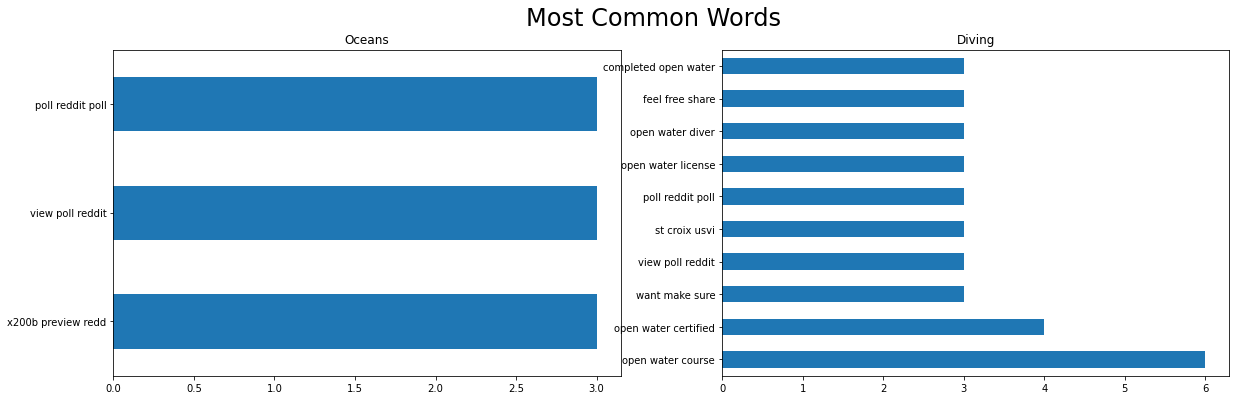

In [84]:
nlp.plot_frequent([oceans_clean, diving_clean], titles)

**Interpretation:** Oceans subreddit has no meaningful trigrams in the text field. Diving has a few, but the max frequency is only 6 occurances in 1200 posts.

In [85]:
web_link_stop_words = ['amp', 'webp', 'www', 'https', 'http', 'png', 'pjpg', 'com']
reddit_stop_words = ['reddit', 'poll', 'redd']
stop_words = text_sk.ENGLISH_STOP_WORDS.union(web_link_stop_words).union(reddit_stop_words)

In [86]:
oceans_clean = nlp.v_transform('selftext', oceans, stopwords=stop_words, ngram_range=(2,2))
diving_clean = nlp.v_transform('selftext', diving, stopwords=stop_words, ngram_range=(2,2))

Shape: (1800, 2941)
Shape: (1200, 9206)


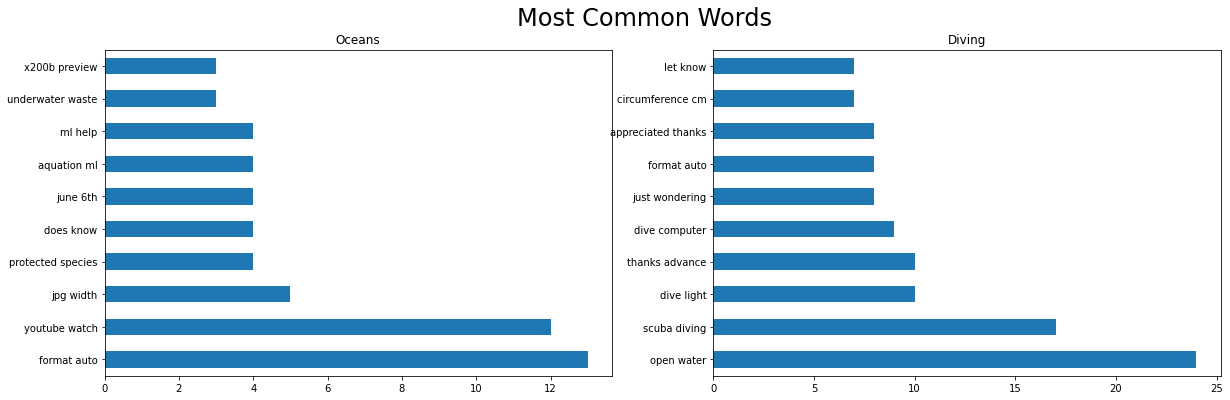

In [87]:
nlp.plot_frequent([oceans_clean, diving_clean], titles)

**Interpretation:** A lot of these seem to be garbage terms as well. Diving has four relevant bigrams, the rest look like filler.

**Title**

In [88]:
oceans_clean = nlp.v_transform('title', oceans, stopwords=stop_words, ngram_range=(3,3))
diving_clean = nlp.v_transform('title', diving, stopwords=stop_words, ngram_range=(3,3))

Shape: (1800, 9190)
Shape: (1200, 4646)


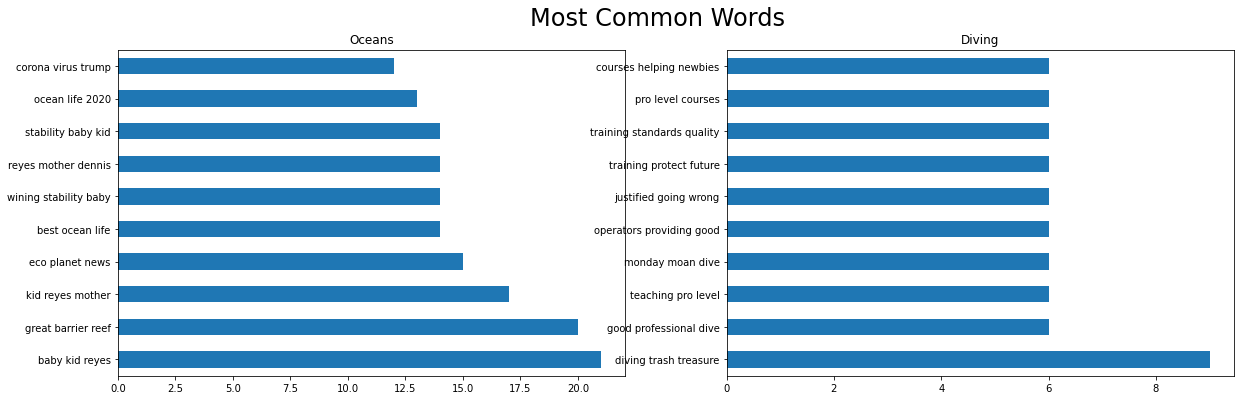

In [89]:
nlp.plot_frequent([oceans_clean, diving_clean], titles)

**Interpretation:** Not many stop words to remove from here.

In [90]:
oceans_clean = nlp.v_transform('title', oceans, stopwords=stop_words, ngram_range=(2,2))
diving_clean = nlp.v_transform('title', diving, stopwords=stop_words, ngram_range=(2,2))

Shape: (1800, 9781)
Shape: (1200, 5147)


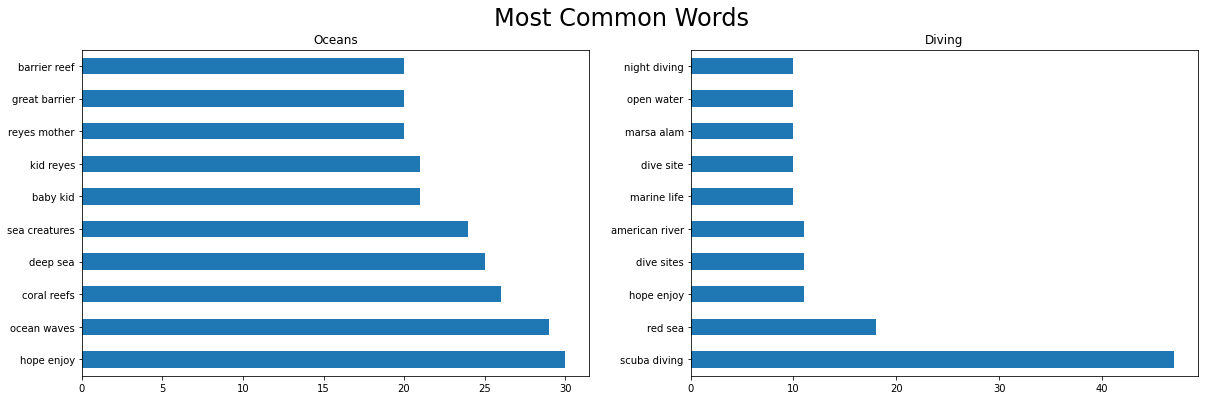

In [91]:
nlp.plot_frequent([oceans_clean, diving_clean], titles)

**Interpretation:** Let's remove 'hope' and 'enjoy.'

In [92]:
# Final list of stopwords
web_link_stop_words = ['amp', 'webp', 'www', 'https', 'http', 'png', 'pjpg', 'com']
reddit_stop_words = ['reddit', 'poll', 'redd']
bland_bigrams_stop_words = ['hope', 'enjoy']

stop_words = text_sk.ENGLISH_STOP_WORDS.union(web_link_stop_words).union(reddit_stop_words).union(bland_bigrams_stop_words)

### What does '[removed]' signify?

In [93]:
has_removed = oceans['all_text'].map(lambda x: 'removed' in x)
oceans.loc[has_removed, :].head(5)

,subreddit,selftext,title,all_text
53,oceans,[removed],looking for information on “The Wall” St Croix...,looking for information on “The Wall” St Croix...
96,oceans,[removed],Table of sea floor temperatures?,Table of sea floor temperatures? [removed]
173,oceans,[removed]\n\n[View Poll](https://www.reddit.co...,"(poll) who is sexually abused more, girls or b...","(poll) who is sexually abused more, girls or b..."
273,oceans,[removed],https://planetsolutionsgroup.com/,https://planetsolutionsgroup.com/ [removed]
437,oceans,[removed],Why are not Sunfish extinct from predators?,Why are not Sunfish extinct from predators? [r...


**Interpretation:** 'removed' seems to cover a range of words. Let's remove it from the dataset.

### Is '[deleted]' in the data?

In [94]:
has_deleted = oceans['all_text'].map(lambda x: '[deleted]' in x)
oceans.loc[has_deleted, :].head()

,subreddit,selftext,title,all_text
626,oceans,[deleted],"After facing rough seas, they shelter crabs, s...","After facing rough seas, they shelter crabs, s..."
627,oceans,[deleted],They faced rough seas before resting at the sh...,They faced rough seas before resting at the sh...
628,oceans,[deleted],They faced rough seas before resting at the sh...,They faced rough seas before resting at the sh...
675,oceans,[deleted],Garbage Accumulation in the Pacific Ocean Over...,Garbage Accumulation in the Pacific Ocean Over...
695,oceans,[deleted],Hello everyone! We are a recently launched nau...,Hello everyone! We are a recently launched nau...


In [96]:
# We remove both [removed] and [deleted] from the dataset like so
oceans = oceans.apply(lambda x: x.replace('[removed]', '').replace('[deleted]', ''))